# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "tuned_1v2:oracle.run2",
    "device": "cuda",
    "lr": 0.0001,
    "labels_source": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "labels_target": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "domains_source": [8, 32, 50],
    "domains_target": [14, 20, 26, 38, 44],
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "n_shot": 3,
    "n_way": 16,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl",
    "x_transforms_source": [],
    "x_transforms_target": [],
    "dataset_seed": 500,
    "seed": 500,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source []
x_transforms_target []
Average magnitude, source: 0.006031243
Average power, source: 4.574067e-05


Average magnitude, target: 0.0051132403
Average power, target: 3.2162818e-05


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 12600], examples_per_second: 27.2173, train_label_loss: 2.7236, 


epoch: 1, [batch: 1260 / 12600], examples_per_second: 3177.5507, train_label_loss: 1.1369, 


epoch: 1, [batch: 2520 / 12600], examples_per_second: 3183.0563, train_label_loss: 0.8533, 


epoch: 1, [batch: 3780 / 12600], examples_per_second: 3164.2855, train_label_loss: 0.6762, 


epoch: 1, [batch: 5040 / 12600], examples_per_second: 3152.6402, train_label_loss: 0.3168, 


epoch: 1, [batch: 6300 / 12600], examples_per_second: 3163.0548, train_label_loss: 0.2019, 


epoch: 1, [batch: 7560 / 12600], examples_per_second: 3166.3356, train_label_loss: 0.3525, 


epoch: 1, [batch: 8820 / 12600], examples_per_second: 3149.3140, train_label_loss: 0.2727, 


epoch: 1, [batch: 10080 / 12600], examples_per_second: 3163.1524, train_label_loss: 0.1705, 


epoch: 1, [batch: 11340 / 12600], examples_per_second: 3173.8174, train_label_loss: 0.1393, 


epoch: 1, source_val_acc_label: 0.7319, target_val_acc_label: 0.5657, source_val_label_loss: 19.9847, target_val_label_loss: 17.0392, 


New best


epoch: 2, [batch: 1 / 12600], examples_per_second: 2.2455, train_label_loss: 0.1575, 


epoch: 2, [batch: 1260 / 12600], examples_per_second: 3172.7949, train_label_loss: 0.1908, 


epoch: 2, [batch: 2520 / 12600], examples_per_second: 3185.7114, train_label_loss: 0.2727, 


epoch: 2, [batch: 3780 / 12600], examples_per_second: 3197.9378, train_label_loss: 0.6185, 


epoch: 2, [batch: 5040 / 12600], examples_per_second: 3175.0822, train_label_loss: 0.1920, 


epoch: 2, [batch: 6300 / 12600], examples_per_second: 3190.5286, train_label_loss: 0.2459, 


epoch: 2, [batch: 7560 / 12600], examples_per_second: 3196.5710, train_label_loss: 0.4570, 


epoch: 2, [batch: 8820 / 12600], examples_per_second: 3185.4682, train_label_loss: 0.1328, 


epoch: 2, [batch: 10080 / 12600], examples_per_second: 3195.4568, train_label_loss: 0.3683, 


epoch: 2, [batch: 11340 / 12600], examples_per_second: 3200.5396, train_label_loss: 0.1678, 


epoch: 2, source_val_acc_label: 0.8695, target_val_acc_label: 0.7116, source_val_label_loss: 0.3595, target_val_label_loss: 0.8667, 


New best


epoch: 3, [batch: 1 / 12600], examples_per_second: 2.2707, train_label_loss: 0.2539, 


epoch: 3, [batch: 1260 / 12600], examples_per_second: 3172.5157, train_label_loss: 0.0859, 


epoch: 3, [batch: 2520 / 12600], examples_per_second: 3176.5986, train_label_loss: 0.1334, 


epoch: 3, [batch: 3780 / 12600], examples_per_second: 3201.3685, train_label_loss: 0.2388, 


epoch: 3, [batch: 5040 / 12600], examples_per_second: 3194.3744, train_label_loss: 0.1669, 


epoch: 3, [batch: 6300 / 12600], examples_per_second: 3207.6363, train_label_loss: 0.2795, 


epoch: 3, [batch: 7560 / 12600], examples_per_second: 3212.4284, train_label_loss: 0.1832, 


epoch: 3, [batch: 8820 / 12600], examples_per_second: 3188.4977, train_label_loss: 0.1784, 


epoch: 3, [batch: 10080 / 12600], examples_per_second: 3175.8655, train_label_loss: 0.0830, 


epoch: 3, [batch: 11340 / 12600], examples_per_second: 3183.8964, train_label_loss: 0.0907, 


epoch: 3, source_val_acc_label: 0.9008, target_val_acc_label: 0.7329, source_val_label_loss: 0.2770, target_val_label_loss: 0.8357, 


New best


epoch: 4, [batch: 1 / 12600], examples_per_second: 2.2611, train_label_loss: 0.0472, 


epoch: 4, [batch: 1260 / 12600], examples_per_second: 3180.6374, train_label_loss: 0.0555, 


epoch: 4, [batch: 2520 / 12600], examples_per_second: 3179.9506, train_label_loss: 0.1350, 


epoch: 4, [batch: 3780 / 12600], examples_per_second: 3196.0067, train_label_loss: 0.4581, 


epoch: 4, [batch: 5040 / 12600], examples_per_second: 3178.2263, train_label_loss: 0.2055, 


epoch: 4, [batch: 6300 / 12600], examples_per_second: 3189.9039, train_label_loss: 0.0776, 


epoch: 4, [batch: 7560 / 12600], examples_per_second: 3194.0073, train_label_loss: 0.1509, 


epoch: 4, [batch: 8820 / 12600], examples_per_second: 3178.1537, train_label_loss: 0.1102, 


epoch: 4, [batch: 10080 / 12600], examples_per_second: 3197.2993, train_label_loss: 0.2397, 


epoch: 4, [batch: 11340 / 12600], examples_per_second: 3184.4647, train_label_loss: 0.1826, 


epoch: 4, source_val_acc_label: 0.9084, target_val_acc_label: 0.7368, source_val_label_loss: 0.2633, target_val_label_loss: 0.8610, 


New best


epoch: 5, [batch: 1 / 12600], examples_per_second: 2.2524, train_label_loss: 0.1519, 


epoch: 5, [batch: 1260 / 12600], examples_per_second: 3179.0648, train_label_loss: 0.0125, 


epoch: 5, [batch: 2520 / 12600], examples_per_second: 3196.8035, train_label_loss: 0.0997, 


epoch: 5, [batch: 3780 / 12600], examples_per_second: 3189.6141, train_label_loss: 0.1991, 


epoch: 5, [batch: 5040 / 12600], examples_per_second: 3173.2396, train_label_loss: 0.1935, 


epoch: 5, [batch: 6300 / 12600], examples_per_second: 3197.1085, train_label_loss: 0.1226, 


epoch: 5, [batch: 7560 / 12600], examples_per_second: 3195.6124, train_label_loss: 0.5849, 


epoch: 5, [batch: 8820 / 12600], examples_per_second: 3169.5026, train_label_loss: 0.1411, 


epoch: 5, [batch: 10080 / 12600], examples_per_second: 3185.4278, train_label_loss: 0.0246, 


epoch: 5, [batch: 11340 / 12600], examples_per_second: 3196.1993, train_label_loss: 0.1650, 


epoch: 5, source_val_acc_label: 0.9112, target_val_acc_label: 0.7456, source_val_label_loss: 0.2559, target_val_label_loss: 0.8325, 


New best


epoch: 6, [batch: 1 / 12600], examples_per_second: 2.2653, train_label_loss: 0.1472, 


epoch: 6, [batch: 1260 / 12600], examples_per_second: 3185.1011, train_label_loss: 0.0866, 


epoch: 6, [batch: 2520 / 12600], examples_per_second: 3202.6173, train_label_loss: 0.1343, 


epoch: 6, [batch: 3780 / 12600], examples_per_second: 3202.0609, train_label_loss: 0.1211, 


epoch: 6, [batch: 5040 / 12600], examples_per_second: 3185.0511, train_label_loss: 0.0122, 


epoch: 6, [batch: 6300 / 12600], examples_per_second: 3195.5065, train_label_loss: 0.1101, 


epoch: 6, [batch: 7560 / 12600], examples_per_second: 3191.2998, train_label_loss: 0.3647, 


epoch: 6, [batch: 8820 / 12600], examples_per_second: 3175.2606, train_label_loss: 0.1005, 


epoch: 6, [batch: 10080 / 12600], examples_per_second: 3185.8968, train_label_loss: 0.1604, 


epoch: 6, [batch: 11340 / 12600], examples_per_second: 3194.9038, train_label_loss: 0.0951, 


epoch: 6, source_val_acc_label: 0.9086, target_val_acc_label: 0.7375, source_val_label_loss: 0.2649, target_val_label_loss: 0.9154, 


epoch: 7, [batch: 1 / 12600], examples_per_second: 2.2602, train_label_loss: 0.0487, 


epoch: 7, [batch: 1260 / 12600], examples_per_second: 3187.0926, train_label_loss: 0.1827, 


epoch: 7, [batch: 2520 / 12600], examples_per_second: 3197.8577, train_label_loss: 0.1386, 


epoch: 7, [batch: 3780 / 12600], examples_per_second: 3192.6376, train_label_loss: 0.1411, 


epoch: 7, [batch: 5040 / 12600], examples_per_second: 3176.1125, train_label_loss: 0.0299, 


epoch: 7, [batch: 6300 / 12600], examples_per_second: 3195.3670, train_label_loss: 0.2456, 


epoch: 7, [batch: 7560 / 12600], examples_per_second: 3197.5989, train_label_loss: 0.0801, 


epoch: 7, [batch: 8820 / 12600], examples_per_second: 3175.9986, train_label_loss: 0.0867, 


epoch: 7, [batch: 10080 / 12600], examples_per_second: 3188.1349, train_label_loss: 0.2159, 


epoch: 7, [batch: 11340 / 12600], examples_per_second: 3189.5682, train_label_loss: 0.2465, 


epoch: 7, source_val_acc_label: 0.9124, target_val_acc_label: 0.7543, source_val_label_loss: 0.2608, target_val_label_loss: 0.8763, 


New best


epoch: 8, [batch: 1 / 12600], examples_per_second: 2.2676, train_label_loss: 0.2376, 


epoch: 8, [batch: 1260 / 12600], examples_per_second: 3191.1789, train_label_loss: 0.0685, 


epoch: 8, [batch: 2520 / 12600], examples_per_second: 3192.0699, train_label_loss: 0.0236, 


epoch: 8, [batch: 3780 / 12600], examples_per_second: 3200.1210, train_label_loss: 0.0800, 


epoch: 8, [batch: 5040 / 12600], examples_per_second: 3171.7276, train_label_loss: 0.0040, 


epoch: 8, [batch: 6300 / 12600], examples_per_second: 3194.4873, train_label_loss: 0.1469, 


epoch: 8, [batch: 7560 / 12600], examples_per_second: 3188.1854, train_label_loss: 0.1114, 


epoch: 8, [batch: 8820 / 12600], examples_per_second: 3185.0046, train_label_loss: 0.0067, 


epoch: 8, [batch: 10080 / 12600], examples_per_second: 3183.0171, train_label_loss: 0.3954, 


epoch: 8, [batch: 11340 / 12600], examples_per_second: 3197.7653, train_label_loss: 0.0086, 


epoch: 8, source_val_acc_label: 0.9151, target_val_acc_label: 0.7539, source_val_label_loss: 0.2658, target_val_label_loss: 0.9223, 


epoch: 9, [batch: 1 / 12600], examples_per_second: 2.2687, train_label_loss: 0.1011, 


epoch: 9, [batch: 1260 / 12600], examples_per_second: 3171.0558, train_label_loss: 0.0330, 


epoch: 9, [batch: 2520 / 12600], examples_per_second: 3194.9013, train_label_loss: 0.0142, 


epoch: 9, [batch: 3780 / 12600], examples_per_second: 3187.5935, train_label_loss: 0.0238, 


epoch: 9, [batch: 5040 / 12600], examples_per_second: 3179.4359, train_label_loss: 0.0925, 


epoch: 9, [batch: 6300 / 12600], examples_per_second: 3186.0445, train_label_loss: 0.1462, 


epoch: 9, [batch: 7560 / 12600], examples_per_second: 3189.5539, train_label_loss: 0.0982, 


epoch: 9, [batch: 8820 / 12600], examples_per_second: 3180.6335, train_label_loss: 0.0124, 


epoch: 9, [batch: 10080 / 12600], examples_per_second: 3174.4518, train_label_loss: 0.0127, 


epoch: 9, [batch: 11340 / 12600], examples_per_second: 3147.9588, train_label_loss: 0.0932, 


epoch: 9, source_val_acc_label: 0.9121, target_val_acc_label: 0.7566, source_val_label_loss: 0.2739, target_val_label_loss: 0.9163, 


New best


epoch: 10, [batch: 1 / 12600], examples_per_second: 2.2449, train_label_loss: 0.0763, 


epoch: 10, [batch: 1260 / 12600], examples_per_second: 3169.1710, train_label_loss: 0.3923, 


epoch: 10, [batch: 2520 / 12600], examples_per_second: 3152.8598, train_label_loss: 0.1031, 


epoch: 10, [batch: 3780 / 12600], examples_per_second: 3158.1672, train_label_loss: 0.0208, 


epoch: 10, [batch: 5040 / 12600], examples_per_second: 3145.9986, train_label_loss: 0.0775, 


epoch: 10, [batch: 6300 / 12600], examples_per_second: 3149.2794, train_label_loss: 0.5201, 


epoch: 10, [batch: 7560 / 12600], examples_per_second: 3155.8060, train_label_loss: 0.1030, 


epoch: 10, [batch: 8820 / 12600], examples_per_second: 3131.9747, train_label_loss: 0.1797, 


epoch: 10, [batch: 10080 / 12600], examples_per_second: 3138.1985, train_label_loss: 0.1486, 


epoch: 10, [batch: 11340 / 12600], examples_per_second: 3168.8142, train_label_loss: 0.0019, 


epoch: 10, source_val_acc_label: 0.9166, target_val_acc_label: 0.7606, source_val_label_loss: 0.2831, target_val_label_loss: 0.9619, 


New best


epoch: 11, [batch: 1 / 12600], examples_per_second: 2.2528, train_label_loss: 0.0117, 


epoch: 11, [batch: 1260 / 12600], examples_per_second: 3178.7466, train_label_loss: 0.0157, 


epoch: 11, [batch: 2520 / 12600], examples_per_second: 3191.1170, train_label_loss: 0.0686, 


epoch: 11, [batch: 3780 / 12600], examples_per_second: 3189.0239, train_label_loss: 0.0776, 


epoch: 11, [batch: 5040 / 12600], examples_per_second: 3175.6592, train_label_loss: 0.0153, 


epoch: 11, [batch: 6300 / 12600], examples_per_second: 3138.6143, train_label_loss: 0.0580, 


epoch: 11, [batch: 7560 / 12600], examples_per_second: 3185.1436, train_label_loss: 0.0241, 


epoch: 11, [batch: 8820 / 12600], examples_per_second: 3181.5610, train_label_loss: 0.0056, 


epoch: 11, [batch: 10080 / 12600], examples_per_second: 3194.9954, train_label_loss: 0.0139, 


epoch: 11, [batch: 11340 / 12600], examples_per_second: 3187.3642, train_label_loss: 0.0663, 


epoch: 11, source_val_acc_label: 0.9160, target_val_acc_label: 0.7596, source_val_label_loss: 0.2796, target_val_label_loss: 0.9285, 


epoch: 12, [batch: 1 / 12600], examples_per_second: 2.2565, train_label_loss: 0.0378, 


epoch: 12, [batch: 1260 / 12600], examples_per_second: 3181.0799, train_label_loss: 0.1212, 


epoch: 12, [batch: 2520 / 12600], examples_per_second: 3174.0202, train_label_loss: 0.0526, 


epoch: 12, [batch: 3780 / 12600], examples_per_second: 3171.0884, train_label_loss: 0.0461, 


epoch: 12, [batch: 5040 / 12600], examples_per_second: 3163.8628, train_label_loss: 0.1462, 


epoch: 12, [batch: 6300 / 12600], examples_per_second: 3188.4344, train_label_loss: 0.2427, 


epoch: 12, [batch: 7560 / 12600], examples_per_second: 3193.9962, train_label_loss: 0.1767, 


epoch: 12, [batch: 8820 / 12600], examples_per_second: 3178.8871, train_label_loss: 0.1536, 


epoch: 12, [batch: 10080 / 12600], examples_per_second: 3174.0102, train_label_loss: 0.0048, 


epoch: 12, [batch: 11340 / 12600], examples_per_second: 3196.6286, train_label_loss: 0.0925, 


epoch: 12, source_val_acc_label: 0.9161, target_val_acc_label: 0.7534, source_val_label_loss: 0.2851, target_val_label_loss: 1.0185, 


epoch: 13, [batch: 1 / 12600], examples_per_second: 2.2597, train_label_loss: 0.0176, 


epoch: 13, [batch: 1260 / 12600], examples_per_second: 3168.7075, train_label_loss: 0.0358, 


epoch: 13, [batch: 2520 / 12600], examples_per_second: 3189.2788, train_label_loss: 0.0151, 


epoch: 13, [batch: 3780 / 12600], examples_per_second: 3198.6525, train_label_loss: 0.0996, 


epoch: 13, [batch: 5040 / 12600], examples_per_second: 3183.3841, train_label_loss: 0.0310, 


epoch: 13, [batch: 6300 / 12600], examples_per_second: 3198.6511, train_label_loss: 0.0065, 


epoch: 13, [batch: 7560 / 12600], examples_per_second: 3197.3186, train_label_loss: 0.1158, 


epoch: 13, [batch: 8820 / 12600], examples_per_second: 3185.1188, train_label_loss: 0.2119, 


epoch: 13, [batch: 10080 / 12600], examples_per_second: 3186.9804, train_label_loss: 0.0398, 


epoch: 13, [batch: 11340 / 12600], examples_per_second: 3190.7590, train_label_loss: 0.1967, 


epoch: 13, source_val_acc_label: 0.9193, target_val_acc_label: 0.7638, source_val_label_loss: 0.2878, target_val_label_loss: 1.0257, 


New best


epoch: 14, [batch: 1 / 12600], examples_per_second: 2.2431, train_label_loss: 0.1444, 


epoch: 14, [batch: 1260 / 12600], examples_per_second: 3179.1510, train_label_loss: 0.0168, 


epoch: 14, [batch: 2520 / 12600], examples_per_second: 3199.4813, train_label_loss: 0.0005, 


epoch: 14, [batch: 3780 / 12600], examples_per_second: 3196.2021, train_label_loss: 0.0566, 


epoch: 14, [batch: 5040 / 12600], examples_per_second: 3173.7160, train_label_loss: 0.0176, 


epoch: 14, [batch: 6300 / 12600], examples_per_second: 3183.4460, train_label_loss: 0.0090, 


epoch: 14, [batch: 7560 / 12600], examples_per_second: 3195.0870, train_label_loss: 0.0001, 


epoch: 14, [batch: 8820 / 12600], examples_per_second: 3181.2691, train_label_loss: 0.0173, 


epoch: 14, [batch: 10080 / 12600], examples_per_second: 3184.9130, train_label_loss: 0.0801, 


epoch: 14, [batch: 11340 / 12600], examples_per_second: 3189.7953, train_label_loss: 0.1071, 


epoch: 14, source_val_acc_label: 0.9180, target_val_acc_label: 0.7588, source_val_label_loss: 0.2960, target_val_label_loss: 1.0399, 


epoch: 15, [batch: 1 / 12600], examples_per_second: 2.2601, train_label_loss: 0.1790, 


epoch: 15, [batch: 1260 / 12600], examples_per_second: 3174.0803, train_label_loss: 0.0155, 


epoch: 15, [batch: 2520 / 12600], examples_per_second: 3189.8789, train_label_loss: 0.0324, 


epoch: 15, [batch: 3780 / 12600], examples_per_second: 3191.8598, train_label_loss: 0.0079, 


epoch: 15, [batch: 5040 / 12600], examples_per_second: 3175.0641, train_label_loss: 0.0170, 


epoch: 15, [batch: 6300 / 12600], examples_per_second: 3194.5409, train_label_loss: 0.0374, 


epoch: 15, [batch: 7560 / 12600], examples_per_second: 3188.3757, train_label_loss: 0.0035, 


epoch: 15, [batch: 8820 / 12600], examples_per_second: 3177.0553, train_label_loss: 0.0755, 


epoch: 15, [batch: 10080 / 12600], examples_per_second: 3183.6877, train_label_loss: 0.0013, 


epoch: 15, [batch: 11340 / 12600], examples_per_second: 3181.1008, train_label_loss: 0.0096, 


epoch: 15, source_val_acc_label: 0.9215, target_val_acc_label: 0.7716, source_val_label_loss: 0.3038, target_val_label_loss: 1.0358, 


New best


epoch: 16, [batch: 1 / 12600], examples_per_second: 2.2590, train_label_loss: 0.1125, 


epoch: 16, [batch: 1260 / 12600], examples_per_second: 3182.2845, train_label_loss: 0.0629, 


epoch: 16, [batch: 2520 / 12600], examples_per_second: 3178.3473, train_label_loss: 0.0009, 


epoch: 16, [batch: 3780 / 12600], examples_per_second: 3189.6601, train_label_loss: 0.1502, 


epoch: 16, [batch: 5040 / 12600], examples_per_second: 3177.9331, train_label_loss: 0.0366, 


epoch: 16, [batch: 6300 / 12600], examples_per_second: 3180.7738, train_label_loss: 0.0169, 


epoch: 16, [batch: 7560 / 12600], examples_per_second: 3183.8247, train_label_loss: 0.0297, 


epoch: 16, [batch: 8820 / 12600], examples_per_second: 3180.1328, train_label_loss: 0.0003, 


epoch: 16, [batch: 10080 / 12600], examples_per_second: 3173.0414, train_label_loss: 0.0063, 


epoch: 16, [batch: 11340 / 12600], examples_per_second: 3182.8712, train_label_loss: 0.0002, 


epoch: 16, source_val_acc_label: 0.9205, target_val_acc_label: 0.7577, source_val_label_loss: 0.3099, target_val_label_loss: 1.1303, 


epoch: 17, [batch: 1 / 12600], examples_per_second: 2.2569, train_label_loss: 0.0045, 


epoch: 17, [batch: 1260 / 12600], examples_per_second: 3174.6899, train_label_loss: 0.0026, 


epoch: 17, [batch: 2520 / 12600], examples_per_second: 3192.5880, train_label_loss: 0.0090, 


epoch: 17, [batch: 3780 / 12600], examples_per_second: 3193.5567, train_label_loss: 0.0020, 


epoch: 17, [batch: 5040 / 12600], examples_per_second: 3176.8303, train_label_loss: 0.0008, 


epoch: 17, [batch: 6300 / 12600], examples_per_second: 3175.8670, train_label_loss: 0.2962, 


epoch: 17, [batch: 7560 / 12600], examples_per_second: 3186.8947, train_label_loss: 0.0772, 


epoch: 17, [batch: 8820 / 12600], examples_per_second: 3183.7910, train_label_loss: 0.0244, 


epoch: 17, [batch: 10080 / 12600], examples_per_second: 3194.7643, train_label_loss: 0.0508, 


epoch: 17, [batch: 11340 / 12600], examples_per_second: 3191.4263, train_label_loss: 0.3239, 


epoch: 17, source_val_acc_label: 0.9176, target_val_acc_label: 0.7712, source_val_label_loss: 0.3268, target_val_label_loss: 1.0657, 


epoch: 18, [batch: 1 / 12600], examples_per_second: 2.2562, train_label_loss: 0.0058, 


epoch: 18, [batch: 1260 / 12600], examples_per_second: 3178.1788, train_label_loss: 0.0153, 


epoch: 18, [batch: 2520 / 12600], examples_per_second: 3187.4992, train_label_loss: 0.2482, 


epoch: 18, [batch: 3780 / 12600], examples_per_second: 3196.2945, train_label_loss: 0.0215, 


epoch: 18, [batch: 5040 / 12600], examples_per_second: 3169.5731, train_label_loss: 0.0011, 


epoch: 18, [batch: 6300 / 12600], examples_per_second: 3185.6174, train_label_loss: 0.1768, 


epoch: 18, [batch: 7560 / 12600], examples_per_second: 3188.6194, train_label_loss: 0.0017, 


epoch: 18, [batch: 8820 / 12600], examples_per_second: 3183.1443, train_label_loss: 0.1943, 


epoch: 18, [batch: 10080 / 12600], examples_per_second: 3182.3809, train_label_loss: 0.0012, 


epoch: 18, [batch: 11340 / 12600], examples_per_second: 3180.2007, train_label_loss: 0.0069, 


epoch: 18, source_val_acc_label: 0.9205, target_val_acc_label: 0.7633, source_val_label_loss: 0.3176, target_val_label_loss: 1.1194, 


epoch: 19, [batch: 1 / 12600], examples_per_second: 2.2570, train_label_loss: 0.1515, 


epoch: 19, [batch: 1260 / 12600], examples_per_second: 3172.5162, train_label_loss: 0.0166, 


epoch: 19, [batch: 2520 / 12600], examples_per_second: 3186.1124, train_label_loss: 0.0001, 


epoch: 19, [batch: 3780 / 12600], examples_per_second: 3181.3753, train_label_loss: 0.0256, 


epoch: 19, [batch: 5040 / 12600], examples_per_second: 3175.2069, train_label_loss: 0.0344, 


epoch: 19, [batch: 6300 / 12600], examples_per_second: 3184.9450, train_label_loss: 0.0025, 


epoch: 19, [batch: 7560 / 12600], examples_per_second: 3186.0143, train_label_loss: 0.1093, 


epoch: 19, [batch: 8820 / 12600], examples_per_second: 3169.3644, train_label_loss: 0.0401, 


epoch: 19, [batch: 10080 / 12600], examples_per_second: 3185.1377, train_label_loss: 0.1076, 


epoch: 19, [batch: 11340 / 12600], examples_per_second: 3178.4657, train_label_loss: 0.0102, 


epoch: 19, source_val_acc_label: 0.9221, target_val_acc_label: 0.7647, source_val_label_loss: 0.2998, target_val_label_loss: 1.1089, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

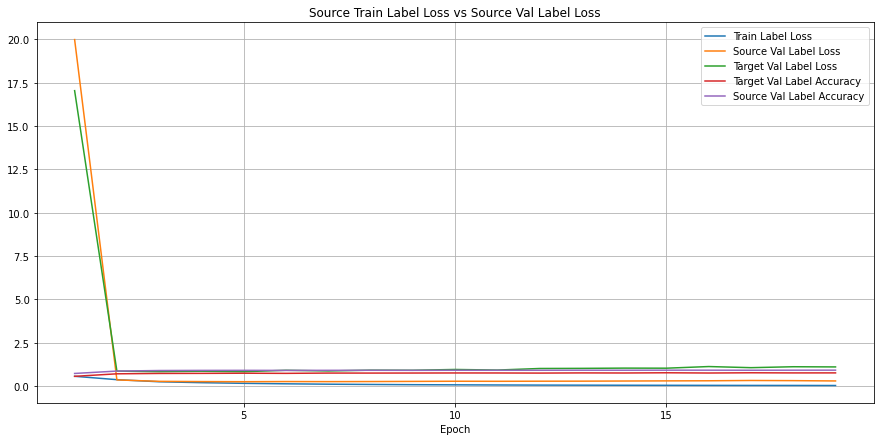

In [16]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

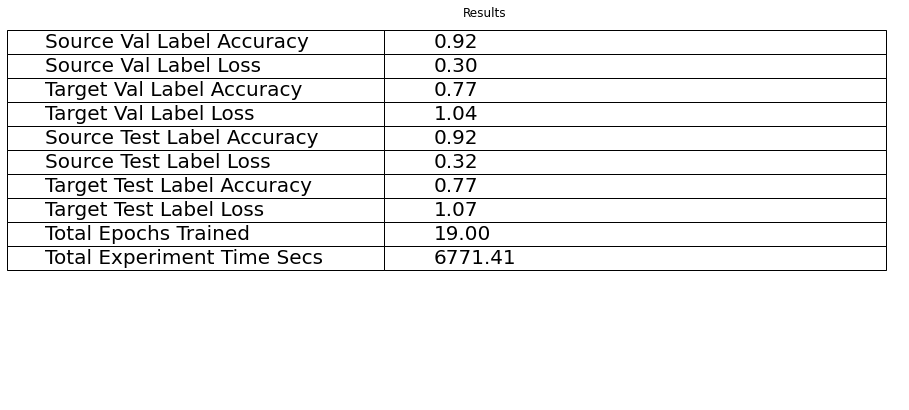

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

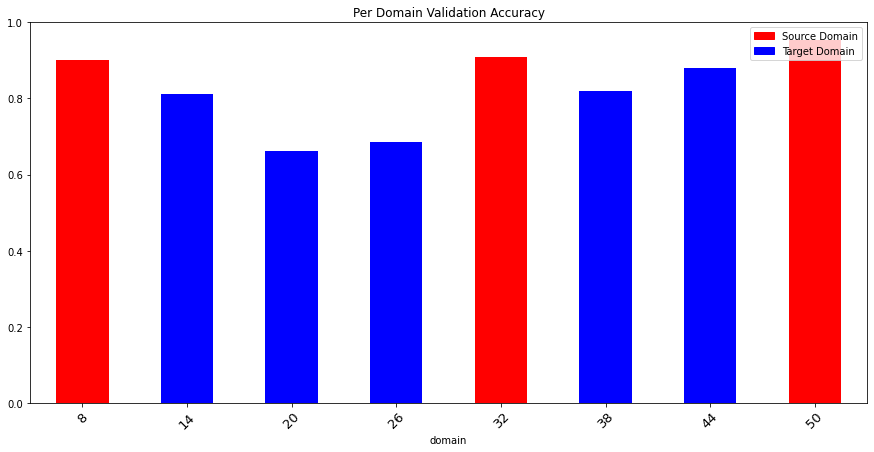

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9182465277777778 Target Test Label Accuracy: 0.7689270833333334
Source Val Label Accuracy: 0.9215277777777777 Target Val Label Accuracy: 0.7715520833333334


In [20]:
json.dumps(experiment)

'{"experiment_name": "tuned_1v2:oracle.run2", "parameters": {"experiment_name": "tuned_1v2:oracle.run2", "device": "cuda", "lr": 0.0001, "labels_source": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "labels_target": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "episode_transforms_source": [], "episode_transforms_target": [], "domains_source": [8, 32, 50], "domains_target": [14, 20, 26, 38, 44], "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "n_shot": 3, "n_way": 16, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape